<a href="https://colab.research.google.com/github/willianszwy/PP2.2.3-Validacao-Cruzada-e-Busca-em-Grade/blob/main/PP2_2_3_Validac%CC%A7a%CC%83o_Cruzada_e_Busca_em_Grade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais Artificiais 2021.1

- **Disciplina**: Redes Neurais Artificiais 2021.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta parte do Projeto Prático diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Busca em Grade

Uma maneira padrão de escolher os parâmetros de um modelo de Machine Learning é por meio de uma busca em grade via força bruta. O algoritmo da busca em grade é dado como segue:

1. Escolha a métrica de desempenho que você deseja maximizar  
2. Escolha o algoritmo de Machine Learning (exemplo: redes neurais artificiais). Em seguida, defina os parâmetros ou hiperparâmetros deste tipo de modelo sobre os quais você dseja otimizar (número de épocas, taxa de aprendizado, etc.) e construa um array de valores a serem testados para cada parâmetro ou hiperparâmetro.  
3. Defina a grade de busca, a qual é dada como o produto cartesiano de cada parâmetro a ser testado. Por exemplo, para os arrays [50, 100, 1000] e [10, 15], tem-se que a grade é [(50,10), (50,15), (100,10), (100,15), (1000,10), (1000,15)].
4. Para cada combinação de parâmetros a serem otimizados, utilize o conjunto de treinamento para realizar uma validação cruzada (holdout ou k-fold) e calcule a métrica de avaliação no conjunto de teste (ou conjuntos de teste)
5. Escolha a combinação de parâmetros que maximizam a métrica de avaliação. Este é o modelo otimizado.

Por que esta abordagem funciona? Porque a busca em grade efetua uma pesquisa extensiva sobre as possíveis combinações de valores para cada um dos parâmetros a serem ajustados. Para cada combinação, ela estima a performance do modelo em dados novos. Por fim, o modelo com melhor métrica de desempenho é escolhido. Tem-se então que este modelo é o que melhor pode vir a generalizar mediante dados nunca antes vistos.

## Efetuando a Busca em Grade sobre Hiperparâmetros das Top-6 RNAs

Considerando a etapa anterior do projeto prático, foram identificadas pelo menos 6 melhores Redes Neurais para o problema da classificação multi-classe da cobertura florestal no conjunto de dados selecionado. Algumas destas redes possuem atributos categóricos como variáveis preditoras, enquanto outras possuem apenas os atributos numéricos como preditores.

A primeira etapa desta segunda parte do projeto consiste em trazer para este notebook estas seis arquiteturas, ressaltando:

1. Número de neurônios ocultos por camada  
2. Função de Ativação  
3. Utilização ou não de atributos categóricos   
4. Desempenho médio +- desvio padrão nos testes anteriores  
5. Número de repetições que a equipe conseguiu realizar para verificar os resultados  

Elabore uma busca em grade sobre estas arquiteturas que contemple variações nos hiperparâmetros a seguir, conforme documentação de [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

A. Solver  (Não usar o LBFGS, pois é mais adequado para datasets pequenos)  
B. Batch Size  
C. Learning Rate Init  
D. Paciência (n_iter_no_change)  
E. Épocas  

Nesta busca em grande, contemple a utilização do objeto [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

## Validação Cruzada k-fold

Na elaboração da busca em grid, vamos avaliar os modelos propostos segundo uma estratégia de validação cruzada ainda não explorada até o momento: a validação cruzada k-fold. Segundo a mesma, o conjunto de dados é particionado em k partes: a cada iteração, separa-se uma das partes para teste e o modelo é treinado com as k-1 partes remanescentes. Valores sugestivos de k na literatura são k = 3, 5 ou 10, pois o custo computacional desta validação dos modelos é alto. A métrica de desempenho é resultante da média dos desempenhos nas k iterações. A figura a seguir ilustra a ideia desta avaliação

<img src = "https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600></img>

Considerando a métrica de desempenho F1-Score, considere a validação cruzada 5-fold para aferir os resultados da busca em grande anterior.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz

--2021-12-18 15:33:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolvendo archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Conectando-se a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 11240707 (11M) [application/x-httpd-php]
Salvando em: “covtype.data.gz”

covtype.data.gz     100%[===================>]  10,72M  3,52MB/s    em 3,0s    

2021-12-18 15:33:14 (3,52 MB/s) - “covtype.data.gz” salvo [11240707/11240707]



In [3]:
!gunzip covtype.data.gz

In [2]:
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']
df_forest_cover = pd.read_csv("covtype.data", names = columns)

In [3]:
df_forest_cover.drop(columns=['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40'],inplace=True)

## 6 melhores arquiteturas

| activation | solver | hidden_layer_sizes | max_iter | atributos categóricos | acurácia média | acurácia desvio padrão | F1-Score média | F1-Score desvio padrão |
|------------|--------|--------------------|----------|-----------------------|----------------|------------------------|----------------|------------------------|
| 'tanh'     | 'adam' | (10, )            |      150 | não                   | 0.7223         | 0.0016                 | 0.4919         | 0.2633                 |
| 'tanh'     | 'adam' | (10, )            |      200 | não                   | 0.7218         | 0.0025                 | 0.5072         | 0.2566                 |
| 'relu'     | 'sgd'  | (10, )            |      300 | não                   | 0.7173         | 0.0005                 | 0.4763         | 0.2617                 |
| 'relu'     | 'adam' | (10, )            |      300 | não                   | 0.7140         | 0.0007                 | 0.5064         | 0.2275                 |
| 'tanh'     | 'adam' | (5, 5)             |      200 | não                   | 0.7097         | 0.0007                 | 0.4587         | 0.2665                 |
| 'identity' | 'sgd'  | (15, )            |      200 | não                   | 0.6967         | 0.0005                 | 0.4198         | 0.2660                 |

## Identificando a mellhor solução

Como resultado da busca em grande com validação cruzada 5-fold, identifique o modelo otimizado com melhor desempenho para o problema. Apresente claramente este modelo, seus parâmetros, hiperparâmetros otimizados e resultados para cada um dos folds avaliados. Esta é a melhor solução identificada em decorrência deste projeto

In [4]:
parameters = {'solver':['sgd','adam'],
              'batch_size':[1,100],
              'hidden_layer_sizes': [(10,),(5,5),(15)],
              'learning_rate_init':[0.01,0.001],
              'n_iter_no_change':[10],
              'max_iter':[150,200],
             }

In [5]:
clf = MLPClassifier()

In [6]:
gridSearch = GridSearchCV(estimator = clf,          
                    param_grid = parameters,
                    n_jobs=-1,
                    cv=5, verbose=10)   

In [7]:
y = df_forest_cover['Cover_Type']
X = df_forest_cover.drop('Cover_Type', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [9]:
X_train_std = (X_train - np.mean(X_train))/np.std(X_train)

In [10]:
X_test_std = (X_test - np.mean(X_train))/np.std(X_train)

In [11]:
gridSearch.fit(X_train_std, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 5/5; 4/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam
[CV 5/5; 4/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.660 total time=51.0min
[CV 5/5; 8/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam
[CV 5/5; 8/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.705 total time=45.8min
[CV 1/5; 12/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam
[CV 1/5; 12/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.689 total time=63.2min
[CV 4/5; 16/48] START batch_size=1, hidde

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 1/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd
[CV 2/5; 1/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd;, score=0.575 total time=28.4min
[CV 4/5; 5/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=sgd
[CV 4/5; 5/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=sgd;, score=0.713 total time=48.8min
[CV 1/5; 10/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 1/5; 10/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.697 total time=42.1min
[CV 4/5; 13/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_it

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 4/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam
[CV 1/5; 4/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.683 total time=30.9min
[CV 3/5; 6/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam
[CV 3/5; 6/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.720 total time=58.1min
[CV 5/5; 11/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 5/5; 11/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.488 total time=30.9min
[CV 2/5; 14/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 4/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam
[CV 4/5; 4/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.660 total time=31.2min
[CV 1/5; 7/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 1/5; 7/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.714 total time=42.8min
[CV 4/5; 9/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd
[CV 4/5; 9/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd;, score=0.488 total time=41.9min
[CV 1/5; 13/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_iter

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 2/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 2/5; 2/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.688 total time=33.5min
[CV 3/5; 7/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 3/5; 7/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.711 total time=112.6min
[CV 4/5; 15/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 4/5; 15/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.704 total time=118.3min
[CV 1/5; 25/48] START batch_size=100, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, 

[CV 5/5; 2/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 5/5; 2/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.685 total time=31.0min
[CV 4/5; 6/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam
[CV 4/5; 6/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.717 total time=38.8min
[CV 3/5; 9/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd
[CV 3/5; 9/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd;, score=0.488 total time=49.7min
[CV 1/5; 14/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_it

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 2/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 1/5; 2/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.693 total time=31.1min
[CV 5/5; 6/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam
[CV 5/5; 6/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.712 total time=55.9min
[CV 3/5; 11/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 3/5; 11/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.365 total time=31.0min
[CV 3/5; 13/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 4/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam
[CV 2/5; 4/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.680 total time=36.1min
[CV 5/5; 7/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 5/5; 7/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.667 total time=90.1min
[CV 5/5; 14/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam
[CV 5/5; 14/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.706 total time=90.6min
[CV 3/5; 20/48] START batch_size=1, hidden_layer_sizes=15, learning_rate_init=0.01, max_iter=200, n_ite

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 2/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 3/5; 2/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.688 total time=33.9min
[CV 4/5; 7/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 4/5; 7/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.711 total time=49.6min
[CV 5/5; 10/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 5/5; 10/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.666 total time=95.1min
[CV 5/5; 17/48] START batch_size=1, hidden_layer_sizes=15, learning_rate_init=0.01, max_iter=150, n_iter_

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 4/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam
[CV 3/5; 4/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.690 total time=48.7min
[CV 4/5; 8/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam
[CV 4/5; 8/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.714 total time=39.1min
[CV 4/5; 11/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 4/5; 11/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.453 total time=41.8min
[CV 2/5; 15/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=200, n_

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 3/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd
[CV 4/5; 3/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=200, n_iter_no_change=10, solver=sgd;, score=0.680 total time=39.2min
[CV 1/5; 8/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam
[CV 1/5; 8/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.714 total time=44.1min
[CV 4/5; 10/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 4/5; 10/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.674 total time=39.5min
[CV 4/5; 14/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=150, n_

/Users/willians/opt/anaconda3/envs/visao_computacional/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 2/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 4/5; 2/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.684 total time=43.5min
[CV 3/5; 8/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam
[CV 3/5; 8/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=200, n_iter_no_change=10, solver=adam;, score=0.713 total time=33.9min
[CV 2/5; 10/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 2/5; 10/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.686 total time=76.0min
[CV 5/5; 15/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=200, 

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'batch_size': [1, 100],
                         'hidden_layer_sizes': [(10,), (5, 5), 15],
                         'learning_rate_init': [0.01, 0.001],
                         'max_iter': [150, 200], 'n_iter_no_change': [10],
                         'solver': ['sgd', 'adam']},
             verbose=10)

In [12]:
pd.DataFrame(gridSearch.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     1834.067088    275.943466         0.044498        0.001062   
1     2074.820235    275.655450         0.054162        0.004743   
2     1860.554830    287.481471         0.045469        0.001720   
3     2374.595786    516.966598         0.056015        0.005332   
4     3290.941878    632.933984         0.043980        0.002620   
5     2933.899747    502.467258         0.041928        0.003198   
6     4472.737686   1549.490562         0.043365        0.002052   
7     2395.877275    265.702565         0.043831        0.004000   
8     2739.628466    489.997089         0.037651        0.001860   
9     3564.465150   1333.273646         0.042708        0.002981   
10    1988.214960    259.392604         0.037593        0.002360   
11    3188.445294    790.771812         0.043958        0.002911   
12    3666.475302   1228.699635         0.039547        0.001968   
13    3888.526180    911.378848         0.049033        0.008808   
14    4288.806610   1712.795569         0.041103        0.001849   
15    3788.390313    215.052532         0.045829        0.004244   
16    2233.102294    828.491797         0.041690        0.002216   
17    2217.031783    467.474346         0.056544        0.007467   
18    2012.701641    215.189174         0.040206        0.000483   
19    2353.783807    349.732746         0.057159        0.004231   
20    4686.947223   1205.626077         0.033536        0.010101   
21    2390.770436    297.348258         0.043638        0.004761   
22    4123.729835    552.789263         0.025659        0.008115   
23    2338.356912    306.452949         0.040906        0.001786   
24     140.376769     38.719498         0.039631        0.002738   
25      77.060044     22.577055         0.045545        0.003333   
26     117.306429     42.350406         0.038714        0.000875   
27      86.165348     29.118015         0.038709        0.000829   
28     234.262950     25.370711         0.039169        0.002531   
29     165.830937     53.342979         0.038379        0.001214   
30     221.583837     48.896178         0.042732        0.006964   
31     174.685827     54.690139         0.040844        0.000944   
32     149.171343     42.872388         0.040389        0.001608   
33     102.878479     17.053121         0.046267        0.011368   
34     103.216205     23.782001         0.040033        0.001547   
35     102.852523     21.712468         0.046100        0.009331   
36     278.266927     59.698071         0.042339        0.003370   
37     219.324113     76.253835         0.042467        0.003565   
38     232.079107     57.399620         0.039831        0.001331   
39     232.678880    116.329471         0.044868        0.008362   
40     167.480826     42.948477         0.042542        0.001994   
41      96.123919     25.481638         0.043030        0.002843   
42     160.317668     43.296669         0.041960        0.000913   
43      86.862273      7.477811         0.041462        0.001273   
44     268.863267      4.103896         0.039585        0.002390   
45     211.156065     42.122830         0.041963        0.002007   
46     265.647352     29.807800         0.032912        0.006575   
47     181.424673     35.309018         0.030776        0.004730   

   param_batch_size param_hidden_layer_sizes param_learning_rate_init  \
0                 1                    (10,)                     0.01   
1                 1                    (10,)                     0.01   
2                 1                    (10,)                     0.01   
3                 1                    (10,)                     0.01   
4                 1                    (10,)                    0.001   
5                 1                    (10,)                    0.001   
6                 1                    (10,)                    0.001   
7                 1                    (10,)                    0.001   
8             

[CV 3/5; 1/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd
[CV 3/5; 1/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=sgd;, score=0.645 total time=30.3min
[CV 1/5; 6/48] START batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam
[CV 1/5; 6/48] END batch_size=1, hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.716 total time=52.9min
[CV 3/5; 10/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam
[CV 3/5; 10/48] END batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.01, max_iter=150, n_iter_no_change=10, solver=adam;, score=0.687 total time=44.3min
[CV 1/5; 15/48] START batch_size=1, hidden_layer_sizes=(5, 5), learning_rate_init=0.001, max_iter=200, n_

In [13]:
print('Melhor configuração:\n', gridSearch.best_params_)

Melhor configuração:
 {'batch_size': 100, 'hidden_layer_sizes': 15, 'learning_rate_init': 0.001, 'max_iter': 150, 'n_iter_no_change': 10, 'solver': 'adam'}


In [21]:
rank = pd.concat([pd.DataFrame(gridSearch.cv_results_["params"]),pd.DataFrame(gridSearch.cv_results_["mean_test_score"], columns=["Accuracy"]),pd.DataFrame(gridSearch.cv_results_["rank_test_score"], columns=["Rank"])],axis=1)

## 6 melhores arquiteturas

In [24]:
rank.sort_values(by=['Rank']).head(6)

batch_size hidden_layer_sizes  learning_rate_init  max_iter  \
45         100                 15               0.001       150   
47         100                 15               0.001       200   
40         100                 15               0.010       150   
46         100                 15               0.001       200   
44         100                 15               0.001       150   
42         100                 15               0.010       200   

    n_iter_no_change solver  Accuracy  Rank  
45                10   adam  0.727480     1  
47                10   adam  0.727043     2  
40                10    sgd  0.726248     3  
46                10    sgd  0.723881     4  
44                10    sgd  0.722904     5  
42                10    sgd  0.722587     6

## Empacotando a solução

Suponha que você deve entregar este classificador ao órgão responsável por administrar o Roosevelt National Park. Para tanto, você deve fazer uma preparação do mesmo para utilização neste cenário. Uma vez que já identificou os melhores parâmetros e hiperparâmetros, o passo remanescente consiste em treinar o modelo com estes valores e todos os dados disponíveis, salvando o conjunto de pesos do modelo ao final para entrega ao cliente. Assim, finalize o projeto prático realizando tais passos.

1. Consulte a documentação a seguir:
https://scikit-learn.org/stable/modules/model_persistence.html  
2. Treine o modelo com todos os dados  
3. Salve o modelo em disco  
4. Construa uma rotina que recupere o modelo em disco  
5. Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

In [26]:
from pickle import dump, load
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
best_model = MLPClassifier(batch_size = 100, hidden_layer_sizes = (15,), learning_rate_init = 0.001, max_iter = 150, n_iter_no_change = 10, solver = 'adam')

2 Treinando o modelo com todos os dados

2.1 Separando os dados em atributos preditores e atributo alvo, rescpectivamente X_train_std e y.

In [28]:
#misturando os dados
df_forest_cover = df_forest_cover.sample(n = len(df_forest_cover))

y = df_forest_cover['Cover_Type']
X = df_forest_cover.drop('Cover_Type', axis=1)

X_train_std = (X - np.mean(X))/np.std(X)

2.2 Treinando

In [29]:
best_model.fit(X_train_std, y)

MLPClassifier(batch_size=100, hidden_layer_sizes=(15,), max_iter=150)

3 Salve o modelo em disco

In [30]:
dump(best_model, open("model.pkl", "wb"))
best_model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 100,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (15,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 150,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

4 Construa uma rotina que recupere o modelo em disco

In [31]:
#Consultando o model feito pela equipe que está no seguinte github:
#https://github.com/willianszwy/PP2.2.3-Validacao-Cruzada-e-Busca-em-Grade

# Descomentar essa linha se der erro
#!git clone https://github.com/willianszwy/PP2.2.3-Validacao-Cruzada-e-Busca-em-Grade.git

#Se você optar por fazer o upload do file manualmente inserindo na pasta de arquivos ao lado, mude o caminho do path... como segue abaixo
#path = "model.pkl"

path = "PP2.2.3-Validacao-Cruzada-e-Busca-em-Grade/model.pkl"

In [33]:
final_model = load(open(path, "rb"))
final_model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 100,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (15,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 150,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

5 Mostre que a rotina é funcional, fazendo previsões com todos os elementos do dataset e exibindo uma matriz de confusão das mesmas

5.1 Fazendo previsões com todos os elementos do dataset

In [34]:
y_pred = final_model.predict(X_train_std)

5.2 Matriz de confusão

In [35]:
cm = confusion_matrix(y, y_pred, labels=final_model.classes_)
print(cm)

[[150342  57832     27      0    136     20   3483]
 [ 49731 228132   3157      0    600   1449    232]
 [     0   6733  24554    789      0   3678      0]
 [     0      8   1119   1185      0    435      0]
 [    29   8103    101      0   1177     82      1]
 [     1   4588   7204    263      3   5308      0]
 [  9155     71      0      0      0      0  11284]]


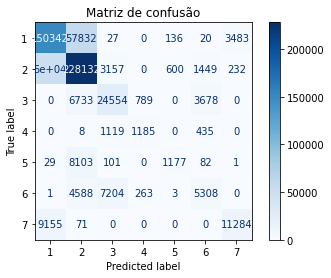

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap = "Blues")
plt.title("Matriz de confusão")
plt.show()

In [37]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.71      0.71    211840
           2       0.75      0.81      0.77    283301
           3       0.68      0.69      0.68     35754
           4       0.53      0.43      0.48      2747
           5       0.61      0.12      0.21      9493
           6       0.48      0.31      0.37     17367
           7       0.75      0.55      0.64     20510

    accuracy                           0.73    581012
   macro avg       0.65      0.52      0.55    581012
weighted avg       0.72      0.73      0.72    581012

